In [1]:
import os
import pandas as pd
import numpy as np
import xarray as xr
from pyproj import Proj
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [2]:
path_save = "/glade/p/cisl/aiml/ai2es/winter_ptypes/precip_rap/"

In [ ]:
source = "ASOS_converted"
files_orig = os.listdir(os.path.join(path_save, source))
files_new = os.listdir(os.path.join(path_save, "ASOS_mixture"))
files_left = list(set(files_orig) - set(files_new))

In [42]:
precip_types = ['ra', 'sn', 'pl', 'fzra']
cols_subset = ['obdate', 'obtime', 'lat', 'lon', 'precip', 'datetime', 'precip_count_byhr']
delta = 0
source = "ASOS_converted"
files = os.listdir(os.path.join(path_save, source))
files.sort()
for i, file in enumerate(files[27:28]):
    df = pd.read_parquet(os.path.join(path_save, source, file))
    df = df[cols_subset]
    if df.groupby(["datetime", "lat", "lon"]).sum().shape[0] < df.shape[0]:
        if delta > (df.shape[0] - df.groupby(["datetime", "lat", "lon"]).sum().shape[0]):
            continue
        else:
            print(i, (df.shape[0] - df.groupby(["datetime", "lat", "lon"]).sum().shape[0]))
            delta = df.shape[0] - df.groupby(["datetime", "lat", "lon"]).sum().shape[0]

0 243


In [43]:
df

,obdate,obtime,lat,lon,precip,datetime,precip_count_byhr
0,01/28/2013,00:55:31,41.770,-88.481,ra,2013-01-28 00:00:00,2
1,01/28/2013,00:00:31,43.171,-86.237,sn,2013-01-28 00:00:00,4
2,01/28/2013,00:00:31,47.457,-115.645,sn,2013-01-28 00:00:00,1
3,01/28/2013,00:00:31,44.883,-93.229,sn,2013-01-28 00:00:00,9
4,01/28/2013,00:00:31,41.196,-112.011,sn,2013-01-28 00:00:00,12
...,...,...,...,...,...,...,...
4516,01/28/2013,23:00:31,40.822,-72.869,ra,2013-01-28 23:00:00,6
4517,01/28/2013,23:35:31,40.779,-73.880,ra,2013-01-28 23:00:00,7
4518,01/28/2013,23:30:31,39.103,-84.419,ra,2013-01-28 23:00:00,12
4519,01/28/2013,23:55:31,38.300,-76.417,ra,2013-01-28 23:00:00,7


In [4]:
columns = ["datetime", "lat", "lon", "report_count", "ra_percent", "sn_percent", "pl_percent", "fzra_percent"]
df_new = pd.DataFrame(columns=columns)

i=0
group = df.groupby(["datetime", "lat", "lon"])
for name, chunk in group:
    if chunk.shape[0] > 1:
        df_new.loc[i, 'datetime'], df_new.loc[i, 'lat'] , df_new.loc[i, 'lon']  = name[0], name[1], name[2]
        df_new.loc[i, 'report_count'] = chunk["precip_count_byhr"].sum()
        for precip_type in precip_types:
            if chunk[chunk['precip'] == precip_type].shape[0]:
                precip_count = float(chunk.loc[chunk['precip'] == precip_type, 'precip_count_byhr'].values)
                df_new.loc[i, f"{precip_type}_percent"] = precip_count / df_new.loc[i, 'report_count']
            else:
                df_new.loc[i, f"{precip_type}_percent"] = 0.0
        break
    i += 1

In [5]:
precip_types = ['ra', 'sn', 'pl', 'fzra']
cols_subset = ['obdate', 'obtime', 'lat', 'lon', 'precip', 'datetime', 'precip_count_byhr']
columns_rap = sorted(list(set(df.columns) - set(cols_subset)))
columns_new = ["datetime", "lat", "lon", "report_count", "ra_percent", "sn_percent", "pl_percent", "fzra_percent"] + columns_rap

source = "ASOS_converted"
files = os.listdir(os.path.join(path_save, source))
files.sort()
for i, file in enumerate(files[27:28]):
    df = pd.read_parquet(os.path.join(path_save, source, file))
    df_new = pd.DataFrame(columns=columns_new)
    i=0
    group = df.groupby(["datetime", "lat", "lon"])
    for name, chunk in group:
        df_new.loc[i, 'datetime'], df_new.loc[i, 'lat'] , df_new.loc[i, 'lon']  = name[0], name[1], name[2]
        df_new.loc[i, columns_rap] = chunk.loc[chunk.index[0], columns_rap]
        df_new.loc[i, 'report_count'] = chunk["precip_count_byhr"].sum()
        for precip_type in precip_types:
            if chunk[chunk['precip'] == precip_type].shape[0]:
                precip_count = float(chunk.loc[chunk['precip'] == precip_type, 'precip_count_byhr'].values)
                df_new.loc[i, f"{precip_type}_percent"] = precip_count / df_new.loc[i, 'report_count']
            else:
                df_new.loc[i, f"{precip_type}_percent"] = 0.0
        i += 1
    df_new.to_parquet(os.path.join(path_save, "ASOS_mixture", file))

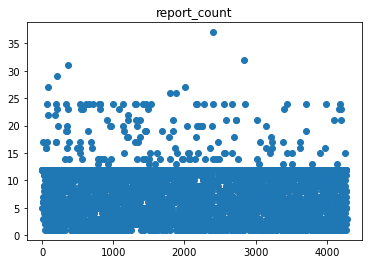

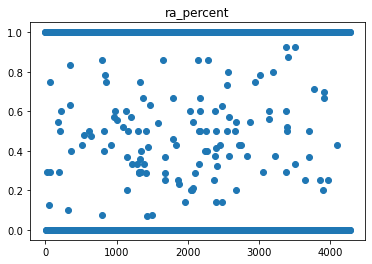

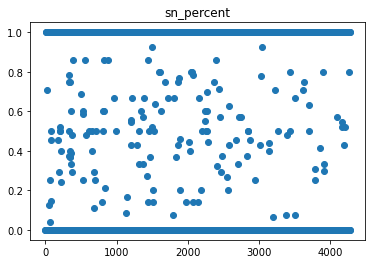

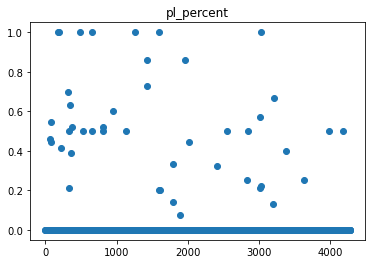

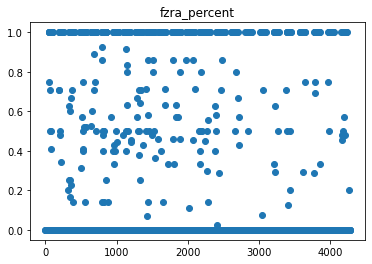

In [6]:
for col in ["report_count", "ra_percent", "sn_percent", "pl_percent", "fzra_percent"]:
    plt.scatter(np.arange(df_new[col].shape[0]), df_new[col])
    plt.title(col)
    plt.show()

In [45]:
def find_coord_indices(lon_array, lat_array, lon_points, lat_points, dist_proj='lcc_RAP'):
    """
    Find indices of nearest lon/lat pair on a grid. Supports rectilinear and curilinear grids.
    lon_points / lat_points must be received as a list.
    Args:
        lon_array (np.array): Longitude values of coarse grid you are matching against
        lat_array (np.array): Latitude values of coarse grid you are matching against
        lon_points (list): List of Longitude points from orginal grid/object
        lat_points (list): List of Latitude points from original grid/object
        dist_proj (str): Name of projection for pyproj to calculate distances
    Returns (list):
        List of i, j (Lon/Lat) indices for coarse grid.
    """
    if dist_proj == 'lcc_WRF':
        proj = Proj(proj='lcc', R=6371229, lat_0=38, lon_0=-97.5, lat_1=32, lat_2=46)  ## from WRF HWT data
    if dist_proj == 'lcc_RAP':
        proj = Proj(proj='lcc', R=6371229, lat_0=25, lon_0=265, lat_1=25, lat_2=25)

    proj_lon, proj_lat = np.array(proj(lon_array, lat_array))  # transform to distances using specified projection
    lonlat = np.column_stack(
        (proj_lon.ravel(), proj_lat.ravel()))  # Stack all coarse x, y distances for array shape (n, 2)
    ll = np.array(proj(lon_points, lat_points)).T  # transform lists of fine grid x, y to match shape (n, 2)
    idx = cdist(lonlat, ll).argmin(0)  # Calculate all distances and get index of minimum

    return np.column_stack((np.unravel_index(idx, lon_array.shape))).tolist()

In [46]:
path_rap = "/glade/p/cisl/aiml/conv_risk_intel/rap_ncei_nc/"
date = "20130603" #yyyymmdd
hour = 1 #0-23
ds = xr.open_dataset(os.path.join(path_rap, date, f"rap_130_{date}_{hour:02d}00_000.nc"))

In [84]:
precip_types = ['ra', 'sn', 'pl', 'fzra']
cols_subset = ['obdate', 'obtime', 'lat', 'lon', 'precip', 'datetime', 'precip_count_byhr']
delta = 0
source = "mPING_converted"
files = os.listdir(os.path.join(path_save, source))
files.sort()
for i, file in enumerate(files[38:39]):
    df = pd.read_parquet(os.path.join(path_save, source, file))
    indices = find_coord_indices(ds['longitude'].values, ds['latitude'].values,
                                 list(df['lon']), list(df['lat']))
    df['lat'] = [ds['latitude'].values[x[0], x[1]] for x in indices]
    df['lon'] = [ds['longitude'].values[x[0], x[1]] for x in indices]
    if df.groupby(["datetime", "lat", "lon"]).sum().shape[0] < df.shape[0]:
        if delta > (df.shape[0] - df.groupby(["datetime", "lat", "lon"]).sum().shape[0]):
            continue
        else:
            print(i, (df.shape[0] - df.groupby(["datetime", "lat", "lon"]).sum().shape[0]))
            delta = df.shape[0] - df.groupby(["datetime", "lat", "lon"]).sum().shape[0]

0 1105


In [85]:
precip_types = ['ra', 'sn', 'pl', 'fzra']
cols_subset = ['obdate', 'obtime', 'lat', 'lon', 'precip', 'datetime', 'precip_count_byhr']
columns_rap = sorted(list(set(df.columns) - set(cols_subset)))
columns_new = ["datetime", "lat", "lon", "report_count", "ra_percent", "sn_percent", "pl_percent", "fzra_percent"] + columns_rap

source = "mPING_converted"
files = os.listdir(os.path.join(path_save, source))
files.sort()
for i, file in enumerate(files[27:28]):
    df = pd.read_parquet(os.path.join(path_save, source, file))
    indices = find_coord_indices(ds['longitude'].values, ds['latitude'].values,
                                 list(df['lon']), list(df['lat']))
    df['lat'] = [ds['latitude'].values[x[0], x[1]] for x in indices]
    df['lon'] = [ds['longitude'].values[x[0], x[1]] for x in indices]
    df_new = pd.DataFrame(columns=columns_new)
    i=0
    group = df.groupby(["datetime", "lat", "lon"])
    for name, chunk in group:
        df_new.loc[i, 'datetime'], df_new.loc[i, 'lat'] , df_new.loc[i, 'lon']  = name[0], name[1], name[2]
        df_new.loc[i, columns_rap] = chunk.loc[chunk.index[0], columns_rap]
        df_new.loc[i, 'report_count'] = chunk["precip_count_byhr"].sum()
        for precip_type in precip_types:
            if chunk[chunk['precip'] == precip_type].shape[0]:
                precip_count = float(chunk.loc[chunk['precip'] == precip_type, 'precip_count_byhr'].sum())
                df_new.loc[i, f"{precip_type}_percent"] = precip_count / df_new.loc[i, 'report_count']
            else:
                df_new.loc[i, f"{precip_type}_percent"] = 0.0
        i += 1
    df_new.to_parquet(os.path.join(path_save, "mPING_mixture", file))

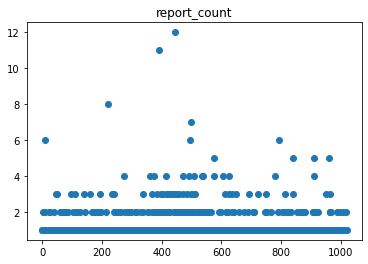

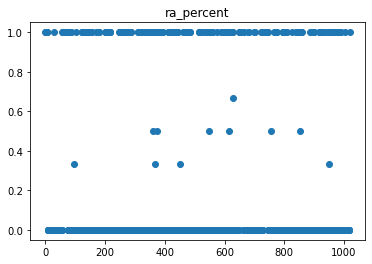

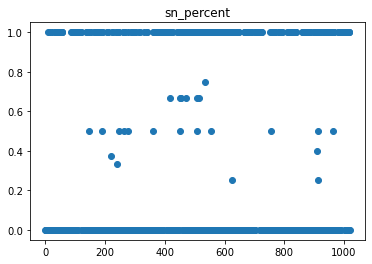

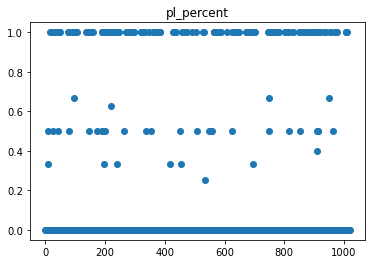

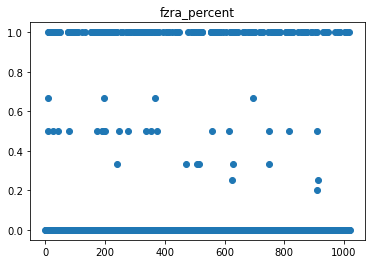

In [86]:
for col in ["report_count", "ra_percent", "sn_percent", "pl_percent", "fzra_percent"]:
    plt.scatter(np.arange(df_new[col].shape[0]), df_new[col])
    plt.title(col)
    plt.show()

In [87]:
df_new.head()

,datetime,lat,lon,report_count,ra_percent,sn_percent,pl_percent,fzra_percent,CFRZR_-,CICEP_-,...,VVEL_775_Pa/s,VVEL_800_Pa/s,VVEL_825_Pa/s,VVEL_850_Pa/s,VVEL_875_Pa/s,VVEL_900_Pa/s,VVEL_925_Pa/s,VVEL_950_Pa/s,VVEL_975_Pa/s,idx
0,2013-01-28 00:00:00,33.6384,248.036,1,1,0,0,0,0,0,...,0.0875959,0.160256,0.168745,0.112581,0.00739288,-0.104084,-0.161642,-0.218102,-0.221696,"[122, 129]"
1,2013-01-28 00:00:00,38.202,274.353,1,1,0,0,0,0,0,...,0.243846,0.222756,0.199995,0.143831,0.0698929,0.020916,-0.0366421,-0.0618525,-0.0341959,"[155, 308]"
2,2013-01-28 00:00:00,38.2101,274.202,1,1,0,0,0,0,0,...,0.243846,0.222756,0.199995,0.175081,0.0698929,0.020916,-0.0366421,-0.0931025,-0.0654459,"[155, 307]"
3,2013-01-28 00:00:00,38.5563,274.384,1,1,0,0,0,0,0,...,-0.00615406,0.0352564,0.074995,0.112581,0.101143,0.145916,0.119608,0.0318975,-0.0341959,"[158, 308]"
4,2013-01-28 00:00:00,39.473,274.925,2,1,0,0,0,0,0,...,-0.412404,-0.402244,-0.362505,-0.262419,-0.180107,-0.135334,-0.130392,-0.0931025,-0.0654459,"[166, 311]"
